In [161]:
%matplotlib inline

import json
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 

mpl.rc('font', family='serif', size=14)

In [2]:
snedir = 'sne_catalog/'
sne_files = glob.glob(snedir + '*.json')

print sne_files

['sne_catalog/SN2011fe.json']


In [42]:
sn_file = sne_files[0]

with open(sn_file, 'r') as f:
    name = sn_file.split('.')[0].split('/')[1]
    datastore = json.load(f)

In [209]:
datastore[name].keys()

[u'discoverer',
 u'redshift',
 u'claimedtype',
 u'maxvisualdate',
 u'sources',
 u'maxabsmag',
 u'ebv',
 u'hostdec',
 u'comovingdist',
 u'maxappmag',
 u'maxdate',
 u'maxvisualband',
 u'hostvelocity',
 u'ra',
 u'hostra',
 u'maxvisualabsmag',
 u'schema',
 u'maxvisualappmag',
 u'lumdist',
 u'maxband',
 u'host',
 u'discoverdate',
 u'photometry',
 u'name',
 u'spectra',
 u'hostoffsetdist',
 u'alias',
 u'velocity',
 u'dec',
 u'hostoffsetang']

In [227]:
sn_type = datastore[name]['claimedtype'][0]['value']
print sn_type

Ia


In [228]:
waves  = []
fluxes = []
times  = []

for spectra in datastore[name]['spectra']:
    flux_unit = spectra['u_fluxes']
    wave_unit = spectra['u_wavelengths']
    time_unit = spectra['u_time']
    
    if flux_unit == 'Uncalibrated':
        continue
    
    time = spectra['time']
    data = np.array(spectra['data'])
    wave = np.array(data[:,0], dtype=np.float32)
    flux = np.array(data[:,1], dtype=np.float32)
    
    if np.max(wave) < 9000 or np.min(wave) > 3000:
        continue

    times.append(np.array(time, dtype=np.float32))
    waves.append(np.array(wave, dtype=np.float32))
    fluxes.append(np.array(flux, dtype=np.float32))

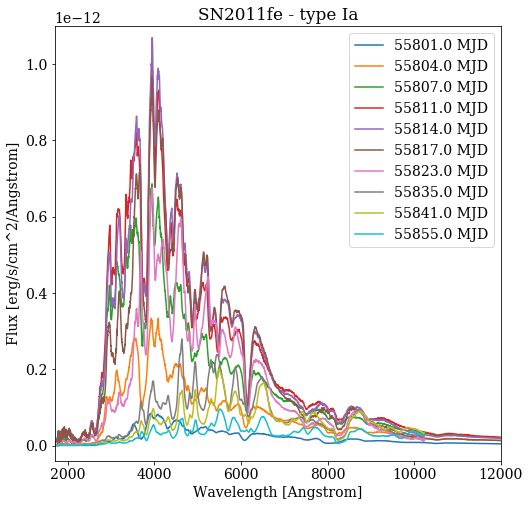

In [238]:
fig, ax = plt.subplots(1,1, figsize=(8,8))


i = 0
for time, wave, flux in zip(times, waves, fluxes):
    i += 1
#     if i > 20:
#         break
            
    ax.plot(wave, flux, label='%s %s' % (time, time_unit))
    ax.set(xlabel='Wavelength [%s]' % wave_unit,
           ylabel='Flux [%s]' % flux_unit,
           title='%s - type %s' % (name, sn_type),
           xlim=[1700, 12000],
           ylim=[-.4e-13, 11e-13])

    ax.legend(loc='upper right')

In [231]:
# Sort observations by time
waves  = [wave for t,wave in sorted(zip(times,waves), 
                                    key=lambda pair: pair[0])]
fluxes = [flux for t,flux in sorted(zip(times,fluxes), 
                                    key=lambda pair: pair[0])]
times = sorted(times)


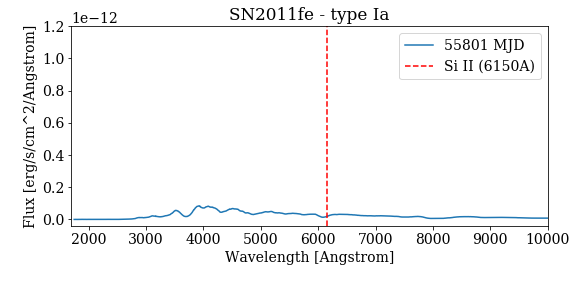

In [232]:
from matplotlib import animation

fig, ax = plt.subplots(1,1, figsize=(8,4))

line, = ax.plot(waves[0], fluxes[0]/np.median(fluxes[0]))

ax.set(xlim=[1700, 10000],
      ylim=[-.4e-13, 1.2e-12],
      xlabel='Wavelength [%s]' % wave_unit,
      ylabel='Flux [%s]' % flux_unit,
      title='%s - type %s' % (name, sn_type))

ax.axvline(6150, ls='--', c='r', label='Si II (6150A)')

def animate(i):
    line.set_data(waves[i], fluxes[i])  # update the data
#     line.set_label('t - tpeak = %0.2f days' % timeobs[i])
    line.set_label('%d %s' % (times[i], time_unit))
    ax.legend(loc='upper right')

    return line,

anim = animation.FuncAnimation(fig, animate, len(fluxes), 
                              interval=200, blit=False)

mpl.rc('animation', html='html5')
fig.tight_layout()

anim.save('%s.gif' % name, dpi=300)

In [197]:
np.max(np.concatenate(fluxes))

1.0692975e-12

In [198]:
np.min(waves[0])

1747.0

In [199]:
from astropy.io import fits
testgal_file = 'my_outlier_detection/output/test.fits'

testgal_f = fits.open(testgal_file)

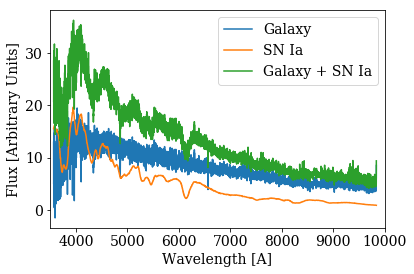

In [200]:
galwave = testgal_f[1].data
galflux = testgal_f[2].data

snflux_resample = spectres(waves[3], fluxes[3], 
                            galwave, spec_errs=None)


norm = np.max(snflux_resample)/np.max(galflux)

plt.plot(galwave, galflux, label='Galaxy')
plt.plot(galwave, snflux_resample/norm, label='SN Ia')

plt.plot(galwave, galflux+snflux_resample/norm, label='Galaxy + SN Ia')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux [Arbitrary Units]')

plt.xlim(3500, 10000)
plt.legend()

In [181]:
import sys


# Function for calculating the left hand side (lhs) positions and widths of the spectral bins from their central wavelengths.
def make_bins(wavelengths, make_rhs="False"):
    bin_widths = np.zeros(wavelengths.shape[0])

    # This option makes the final entry in the left hand sides array the right hand side of the final bin
    if make_rhs == "True":
        bin_lhs = np.zeros(wavelengths.shape[0]+1)
        #The first lhs position is assumed to be as far from the first central wavelength as the rhs of the first bin.
        bin_lhs[0] = wavelengths[0] - (wavelengths[1]-wavelengths[0])/2
        bin_widths[-1] = (wavelengths[-1] - wavelengths[-2])
        bin_lhs[-1] = wavelengths[-1] + (wavelengths[-1]-wavelengths[-2])/2
        bin_lhs[1:-1] = (wavelengths[1:] + wavelengths[:-1])/2
        bin_widths[:-1] = bin_lhs[1:-1]-bin_lhs[:-2]

    # Otherwise just return the lhs positions of each bin
    else:
        bin_lhs = np.zeros(wavelengths.shape[0])
        bin_lhs[0] = wavelengths[0] - (wavelengths[1]-wavelengths[0])/2
        bin_widths[-1] = (wavelengths[-1] - wavelengths[-2])
        bin_lhs[1:] = (wavelengths[1:] + wavelengths[:-1])/2
        bin_widths[:-1] = bin_lhs[1:]-bin_lhs[:-1]

    return bin_lhs, bin_widths



# Function for performing spectral resampling on a spectrum or array of spectra.
def spectres(spec_wavs, spec_fluxes, resampling, spec_errs=None):

    # Generate arrays of left hand side positions and widths for the old and new bins
    filter_lhs, filter_widths = make_bins(resampling, make_rhs="True")
    spec_lhs, spec_widths = make_bins(spec_wavs)


    # Check that the range of wavelengths to be resampled onto falls within the initial sampling region
    if filter_lhs[0] < spec_lhs[0] or filter_lhs[-1] > spec_lhs[-1]:
        print("Spec_lhs, filter_lhs, filter_rhs, spec_rhs ", spec_lhs[0], filter_lhs[0], filter_lhs[-1], spec_lhs[-1])
        sys.exit("spectres was passed a spectrum which did not cover the full wavelength range of the specified filter curve.")
    

    #Generate output arrays to be populated
    if spec_fluxes.ndim == 1:
        resampled = np.zeros((resampling.shape[0]))

    elif spec_fluxes.ndim == 2:
        resampled = np.zeros((len(resampling), spec_fluxes.shape[1]))

    if spec_errs is not None:
        if spec_errs.shape != spec_fluxes.shape:
            sys.exit("If specified, spec_errs must be the same shape as spec_fluxes.")
        else:
            resampled_errs = np.copy(resampled)

    start = 0
    stop = 0

    # Calculate the new spectral flux and uncertainty values, loop over the new bins
    for j in range(len(filter_lhs)-1):

        # Find the first old bin which is partially covered by the new bin
        while spec_lhs[start+1] <= filter_lhs[j]:
            start += 1

        # Find the last old bin which is partially covered by the new bin
        while spec_lhs[stop+1] < filter_lhs[j+1]:
            stop += 1

        if spec_fluxes.ndim == 1:

            # If the new bin falls entirely within one old bin the are the same the new flux and new error are the same as for that bin
            if stop == start:

                resampled[j] = spec_fluxes[start]
                if spec_errs is not None:
                    resampled_errs[j] = spec_errs[start]

            # Otherwise multiply the first and last old bin widths by P_ij, all the ones in between have P_ij = 1 
            else:

                start_factor = (spec_lhs[start+1] - filter_lhs[j])/(spec_lhs[start+1] - spec_lhs[start])
                end_factor = (filter_lhs[j+1] - spec_lhs[stop])/(spec_lhs[stop+1] - spec_lhs[stop])

                spec_widths[start] *= start_factor
                spec_widths[stop] *= end_factor

                # Populate the resampled spectrum and uncertainty arrays
                resampled[j] = np.sum(spec_widths[start:stop+1]*spec_fluxes[start:stop+1])/np.sum(spec_widths[start:stop+1])

                if spec_errs is not None:
                    resampled_errs[j] = np.sqrt(np.sum((spec_widths[start:stop+1]*spec_errs[start:stop+1])**2))/np.sum(spec_widths[start:stop+1])
                
                # Put back the old bin widths to their initial values for later use
                spec_widths[start] /= start_factor
                spec_widths[stop] /= end_factor


        # The same as above, except operates on each row of the array, resampling all of the input models
        elif spec_fluxes.ndim == 2:

            if stop == start:

                resampled[j, :] = spec_fluxes[start, :]
                if spec_errs is not None:
                    resampled_errs[j, :] = spec_errs[start, :]

            else:

                start_factor = (spec_lhs[start+1] - filter_lhs[j])/(spec_lhs[start+1] - spec_lhs[start])
                end_factor = (filter_lhs[j+1] - spec_lhs[stop])/(spec_lhs[stop+1] - spec_lhs[stop])

                spec_widths[start] *= start_factor
                spec_widths[stop] *= end_factor

                resampled[j, :] = np.sum(np.expand_dims(spec_widths[start:stop+1], axis=1)*spec_fluxes[start:stop+1, :], axis=0)/np.sum(spec_widths[start:stop+1])
                
                if spec_errs is not None:
                    resampled_errs[j, :] = np.sqrt(np.sum((np.expand_dims(spec_widths[start:stop+1], axis=1)*spec_errs[start:stop+1])**2, axis=0))/np.sum(spec_widths[start:stop+1])
                
                spec_widths[start] /= start_factor
                spec_widths[stop] /= end_factor


    # If errors were supplied return the resampled spectrum and error arrays
    if spec_errs is not None:
        return resampled, resampled_errs

    # Otherwise just return the resampled spectrum array
    else: 
        return resampled
